### Simple EDA 

In [1]:
from utils import (read_twitter_file,
                   create_datasets)
import pandas as pd
from matplotlib import pyplot as pyplot
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle
from matplotlib import pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
## create dataset with 100_000 samples
df = create_datasets(sub_sampling=10_000, return_type="df")

In [15]:
df

,labels,tweet
0,1.0,you doesn't care about my feelings but when yo...
1,1.0,"going to follow some new people , retweet if y..."
2,0.0,syndresi i . n . r . h . ( rock progressivo it...
3,0.0,happy birthday david tennant . i miss him as t...
4,0.0,feeling some kind of way smh
...,...,...
9995,1.0,watching crazy / beautiful i < 3 this movie
9996,1.0,"spending da day in b-more with "" her "" ahhh ca..."
9997,1.0,finally in a good mood sleeepp
9998,0.0,"loool wai boring . "" <user> i hate it when my ..."


### 1 - Label distribution

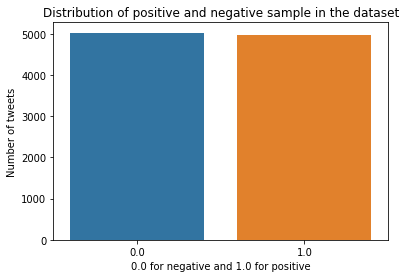

In [16]:
g = sns.countplot(data=df, x="labels")
g.set_title("Distribution of positive and negative sample in the dataset")
g.set_xlabel("0.0 for negative and 1.0 for positive")
g.set_ylabel("Number of tweets");

We can see a perfect balance in label distribution.


### 2 - Number of BERT tokens

In [20]:
from transformers import AutoTokenizer

BERT_MODEL = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, batch_size=16) 
df["embeddings"] = df["tweet"].progress_apply(
    lambda x : tokenizer(x, return_tensors="pt", truncation=True)["input_ids"]
)

  0%|          | 0/10000 [00:00<?, ?it/s]

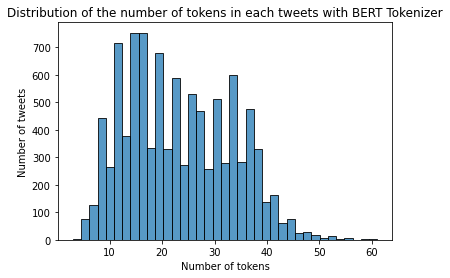

In [27]:
df["nb_tokens"] = df["embeddings"].apply(lambda x : x.size()[1])
g = sns.histplot(data=df, x='nb_tokens')
g.set_title("Distribution of the number of tokens in each tweets with BERT Tokenizer")
g.set_xlabel("Number of tokens")
g.set_ylabel("Number of tweets");

All the tweets fits the limit of BERT style and BERTweet.

### 3 - Clustering ob BERTweet embeddings


We start with a first clustering of 10 000 tweets and see if we can genelerize it.

In [2]:
from utils import MyDataset
%autoreload 2

In [9]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [40]:
## BERTweet 
from transformers import (AutoModel, AutoTokenizer)
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns

tqdm.pandas()

EMB_MODEL = "vinai/bertweet-base"

emb_tok = AutoTokenizer.from_pretrained(EMB_MODEL)
emb_tok.add_tokens(["<user>"])
emb_model = AutoModel.from_pretrained(EMB_MODEL).to(mps_device)

In [12]:
ds = create_datasets(sub_sampling=10_000)
ds = MyDataset(data=ds, 
          tokenizer=emb_tok, 
          max_length=130,
          device=mps_device)


process_dl = DataLoader(ds,
                        batch_size=32,
                        shuffle=False)

process_embs = []
for batch in tqdm(process_dl):
    batch.pop("labels")
    process_embs.append(
        emb_model(
                **batch
            ).last_hidden_state[:, 0, :].detach()    
    )

  0%|          | 0/313 [00:00<?, ?it/s]

In [39]:
df = pd.DataFrame(ds.initial_data)
all_embs = torch.cat(process_embs).to("cpu").numpy()
df["embeddings"] = all_embs.tolist()

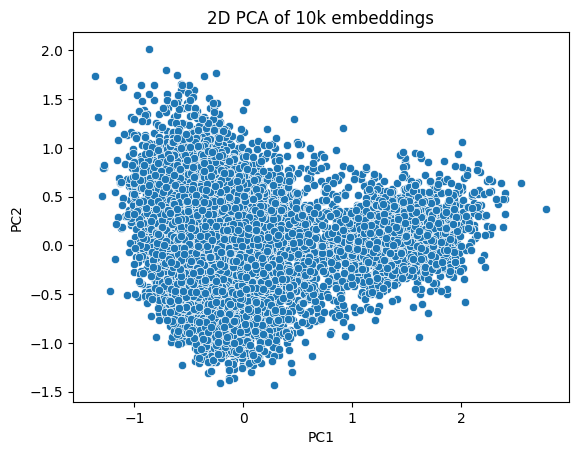

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
 
# Fit and transform data
pca_features = pca.fit_transform(all_embs)
df[["PC1", "PC2"]] = pca_features
pipe = lambda base, comms : [comm(base) for comm in comms]

def plot_pca(colors=None, ax=None):
    df["colors"] = colors
    pipe(
        sns.scatterplot(
            data=df,
            x="PC1",
            y="PC2",
            ax=ax,
        ) if colors is None else
        sns.scatterplot(
            data=df,
            x="PC1",
            y="PC2",
            hue="colors",
            ax=ax,
        ),
        [
            lambda x : x.set_title("2D PCA of 10k embeddings"),
            lambda x : x.set_xlabel("PC1"),
            lambda x : x.set_ylabel("PC2"),
        ]
    )
    if(colors is not None):
        return df
    
plot_pca();

0it [00:00, ?it/s]

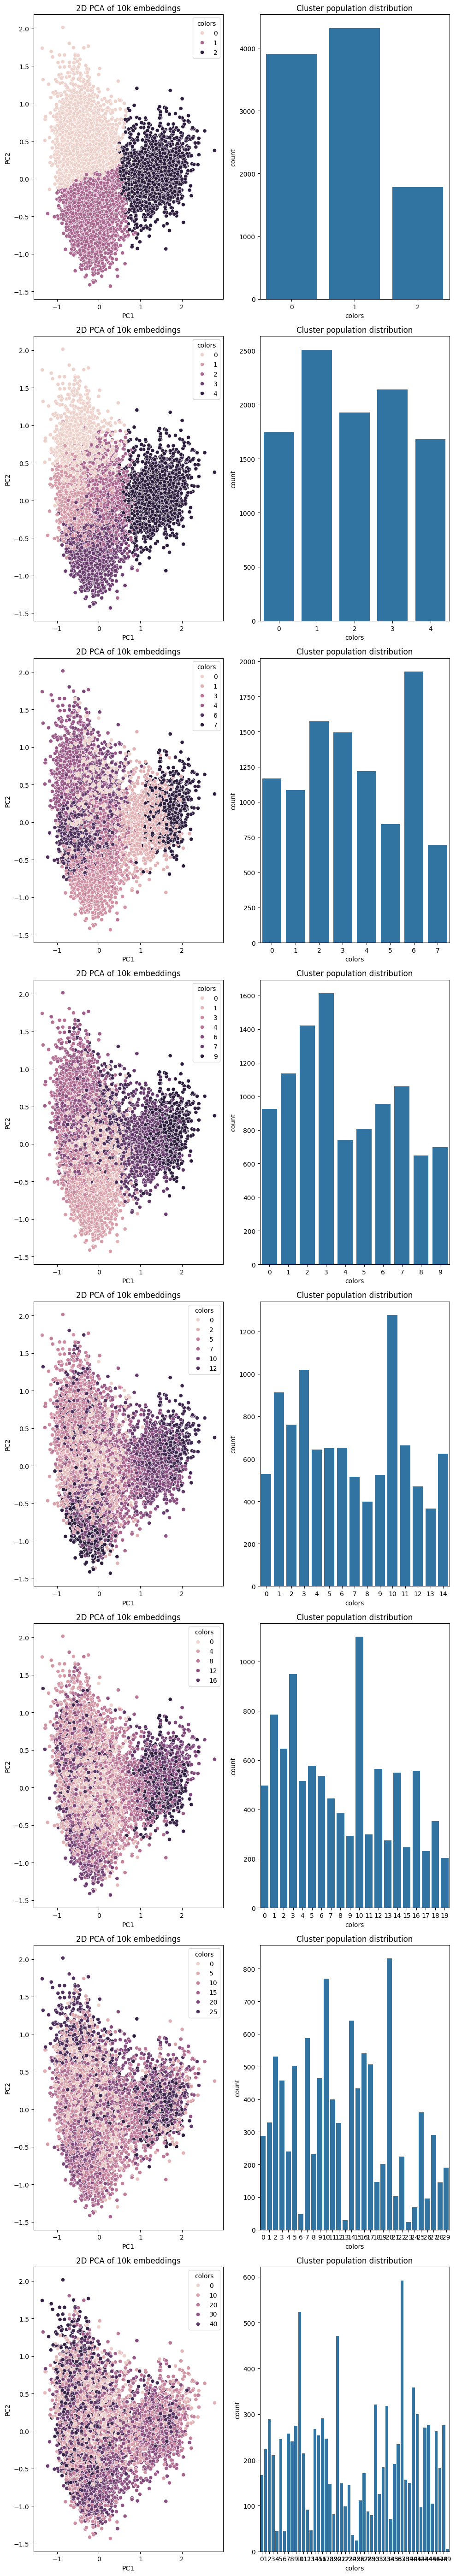

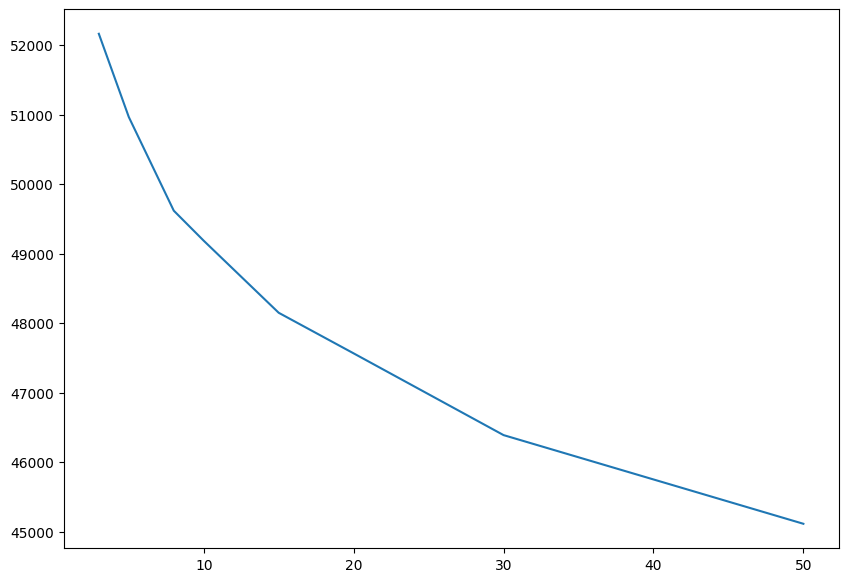

In [68]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distortions = []
Ks = [3, 5, 8, 10, 15, 20, 30, 50]
assert(len(Ks) % 2 == 0) ## for layout purpose
f, a = plt.subplots(len(Ks), 2 , figsize=(10, 7 * len(Ks)))
for k, ax in tqdm(zip(Ks, a)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(all_embs)
    
    ndf = plot_pca(colors=kmeans.labels_, ax=ax[0])
    g = sns.countplot(data=ndf, x="colors", ax=ax[1])
    g.set_title("Cluster population distribution")
    distortions.append(kmeans.inertia_)

plt.tight_layout()
plt.show()

f = plt.figure(figsize=(10, 7))
plt.plot(Ks, distortions)

In [70]:
distortions = []
Ks = np.arange(1,200,2)
for k in tqdm(Ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(all_embs)
    distortions.append(kmeans.inertia_)

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
from kneed import KneeLocator
kn = KneeLocator(Ks, distortions, curve='convex', direction='decreasing')
print(kn.knee)

39


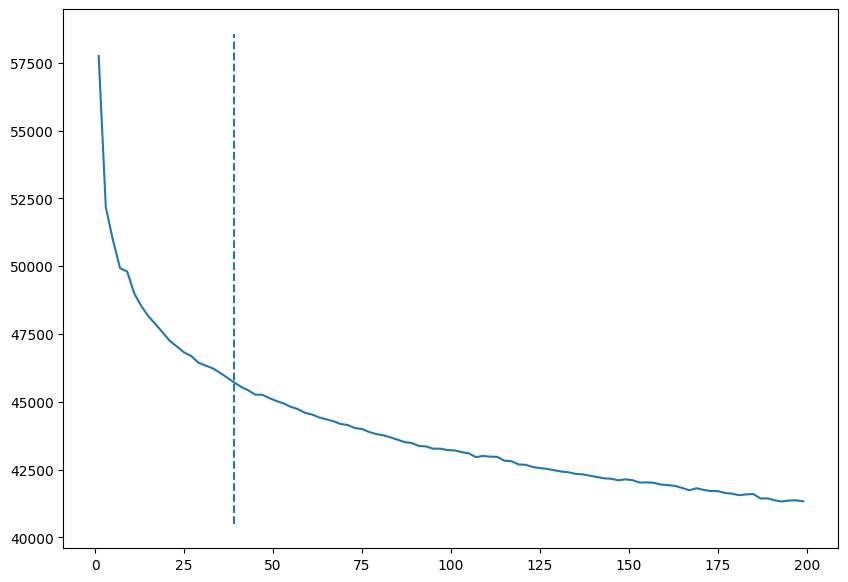

In [75]:
f = plt.figure(figsize=(10, 7))
plt.plot(Ks, distortions)
plt.vlines(kn.knee, ymin=plt.ylim()[0], ymax=plt.ylim()[1], linestyle="dashed")

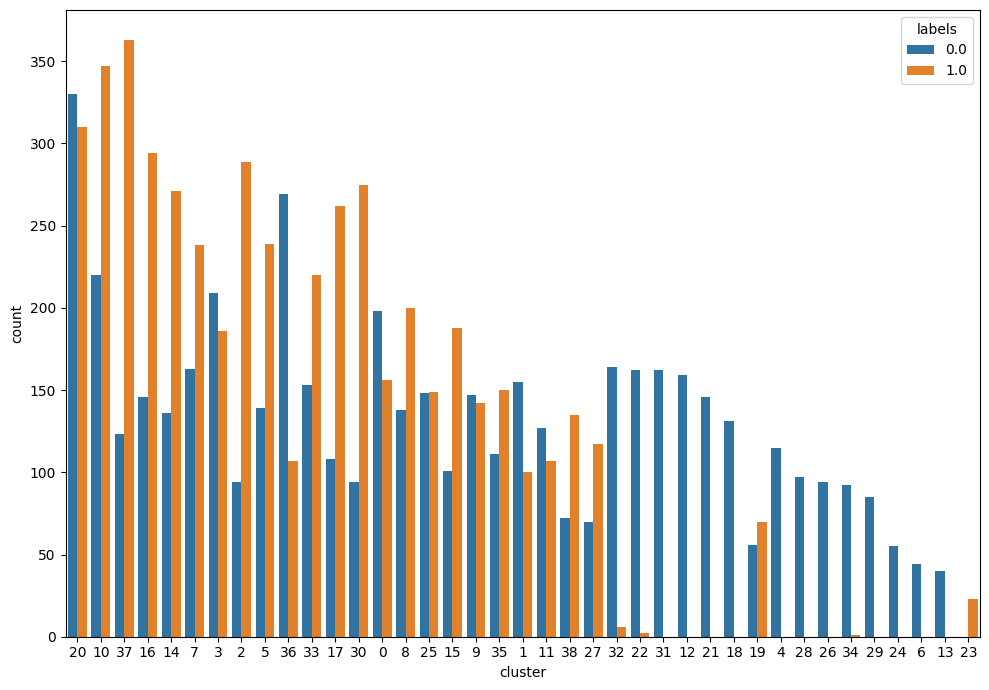

In [95]:
kmeans = KMeans(n_clusters=kn.knee, random_state=0, n_init="auto").fit(all_embs)
df["cluster"] = kmeans.labels_

f = plt.figure(figsize=(10, 7))
sns.countplot(data=df, x="cluster", order = df['cluster'].value_counts().index, hue="labels")
plt.tight_layout()

In [96]:
## examples of clusters

for c in range(kn.knee):
    ## samples of each cluster
    print("Cluster : ", c, f"(POPULATION : {len(df[df.cluster == c].index)} (1-ratio : {round(df[df.cluster == c]['labels'].sum() * 100/ len(df[df.cluster == c].index), 3)}%))")
    [print(f"\t - {t}") for t in df[df.cluster == c].sample(5).tweet]

Cluster :  0 (POPULATION : 354 (1-ratio : 44.068%))
	 - <user> i took mine down yesterday ... it was so sad .
	 - <user> i'm assuming u got the kids today ? email me ! ! ! u didn't apply did u :-/
	 - just got cock slapped and all i wanted was some toast .
	 - <user> yes well he slept from like 8 till 10 i tried keeping him up for a little & he just kept smiling & his eyes would close lol
	 - <user> have so many questions to ask bout that now . you'll understand tomorrow when i tell ya lol . hope u get it sorted tomorrow .
Cluster :  1 (POPULATION : 255 (1-ratio : 39.216%))
	 - <user> i'm sure it can't be that bad ! we've got ages to go , and as long as you organise yourself , you'll get it all done !
	 - " <user> <user> tell him us lot gotta go nando's soon ! xxx " next week or the week after ... don't be a flop this time xx
	 - <user> goood , ooh can't get enough ay hahha , erm nope handed out loads of c.vs not long ago , but no one wants me #notevenmaccies
	 - <user> i won't be in s

### 4 - Proportion of `<unk>` tokens

In [90]:
unk_counts = [i["input_ids"].tolist().count(emb_tok.unk_token_id) for i in ds]

In [92]:
df["unk_counts"] = unk_counts

df["unk_counts"].value_counts()

unk_counts
0    9949
1      38
2      12
3       1
Name: count, dtype: int64

In [99]:
np.savetxt("clustering_center.npy", kmeans.cluster_centers_)

No significant `<unk>` representation

#### 5 - Generalization of the previously computed cluster to the rest of the datapoints


We compute for each tweet, the closest cluster center (previously computed) with euclidean distance and cosine similarity. We can see that the two values `c_cos` and `c_dl2` match so using both metrics is equivalent.

In [28]:
## intermediate checkpoint

def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

negdata = load_pickle("v3_clusters.pkl")
posdata = load_pickle("pos1_clusters.pkl")
posdata += load_pickle("pos2_clusters.pkl")
posdata += load_pickle("pos3_clusters.pkl")

negdata = pd.DataFrame(negdata)
posdata = pd.DataFrame(posdata)
negdata["label"] = -1
posdata["label"] = 1
negdata.columns = ["idx", "c_dl2", "c_cos", "embedding", "label"]
posdata.columns = ["idx", "c_dl2", "c_cos", "embedding", "label"]
N_NEG = len(negdata)
N_POS = len(posdata)
negdata = negdata.iloc[:min(N_POS, N_NEG)] 
posdata = posdata.iloc[:min(N_POS, N_NEG)]

posdata["idx"] = posdata["idx"] + 1 + negdata["idx"].max()


print("Number of pos : ", N_POS)
print("Number of neg : ", N_NEG)

data = pd.concat(
    [negdata, posdata]   
).reset_index()

del negdata
del posdata

data.head(5)

Number of pos :  500000
Number of neg :  800000


,index,idx,c_dl2,c_cos,embedding,label
0,0,0,32,32,"[-0.15626647, 0.19423367, 0.13614166, -0.00518...",-1
1,1,1,15,15,"[0.17122753, 0.30579382, 0.18281512, -0.148204...",-1
2,2,2,38,38,"[0.011353046, 0.048151877, 0.2444211, -0.15453...",-1
3,3,3,30,30,"[0.21156709, 0.32710785, 0.063177355, -0.15516...",-1
4,4,4,14,14,"[0.08792307, 0.27733427, 0.17248015, -0.133992...",-1


In [25]:
print("nb samples : ", len(data))

nb samples :  1000000


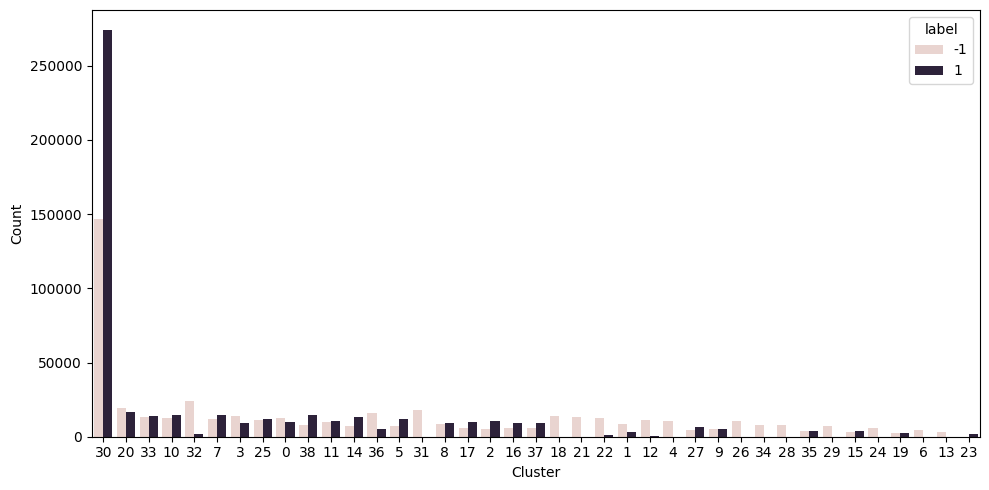

In [16]:
f = plt.figure(figsize=(10, 5))
g = sns.countplot(data=ds, x="c_cos", order=ds['c_cos'].value_counts().index, hue="label")
g.set_xlabel("Cluster")
g.set_ylabel("Count")
plt.tight_layout()

def sample_equally_per_cluster(data, n=200_000, cluster_dist_sampling=None, cluster_key="c_cos"):
    ## we return a subdata of n sample selecting as equally as possible from each cluster
    N_cluster = len(data[cluster_key].unique())
    if(cluster_dist_sampling is None):
        ## default dist in uniform
        dist = np.ones(N_cluster) / N_cluster
    sel_idx = np.random.choice(data.index, size=n, replace=True, p=dist) ## with replacement to allow oversampling of low population cluster
    return data.loc[sel_idx]


We unfortunately see that it doesn't generalizes at all and nearly all the tweets are in cluster 30. We have no choice but to compute a new clustering will all the embeddings that we have.

### 5 - Final clustering

In [39]:
from kneed import KneeLocator
from time import time
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


def compute_large_clustering(embdf):
    all_embs = np.vstack(embdf.embedding)
    distortions = []
    Ks = np.arange(3,50,10)
    for k in tqdm(Ks):
        start = time()
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(all_embs)
        distortions.append(kmeans.inertia_)
        print(f"For {k} : clustering time : {round(time() - start, 2)}s")
    kn = KneeLocator(Ks, distortions, curve='convex', direction='decreasing')
    return kn.knee ## we return the correct number of cluster

In [40]:
K = compute_large_clustering(data)

  0%|          | 0/5 [00:00<?, ?it/s]

For 3 : clustering time : 11.08s
For 13 : clustering time : 30.36s
For 23 : clustering time : 79.49s
For 33 : clustering time : 83.31s
For 43 : clustering time : 98.28s


In [43]:
all_embs = np.vstack(data.embedding)
kmeans = KMeans(n_clusters=13, random_state=0, n_init="auto").fit(all_embs)
data["c"] = kmeans.labels_

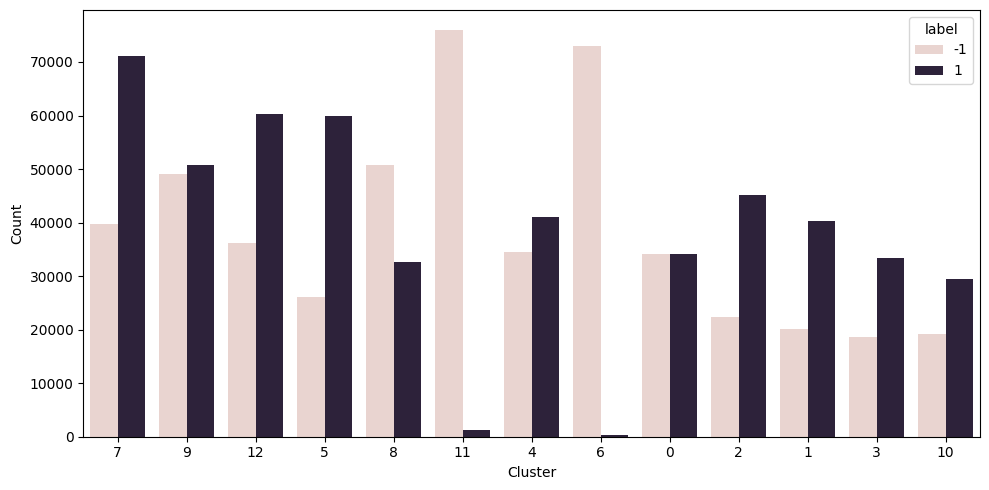

In [47]:
f = plt.figure(figsize=(10, 5))
g = sns.countplot(data=data, x="c", order=data['c'].value_counts().index, hue="label")
g.set_xlabel("Cluster")
g.set_ylabel("Count")
plt.tight_layout()

In [48]:
## population distribution in each cluster :
data[["c", "idx"]].groupby("c").count().T

c,0,1,2,3,4,5,6,7,8,9,10,11,12
idx,68328,60391,67402,52084,75563,86066,73314,110971,83550,99850,48612,77215,96654


Uniform split :

In [52]:
## If we take all the samples from the minimum cluster, the total size would be : 
data[["c", "idx"]].groupby("c").count().min()[0] * 13

/var/folders/vc/y26l34t12jn52x3v2rxd9g1h0000gn/T/ipykernel_39923/2207850304.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[["c", "idx"]].groupby("c").count().min()[0] * 13


631956

In [80]:
def uniform_split(cds, n_samples):
    """
        select from the clusters uniformly to get a 
        dataset of n_samples
    """

    n_cluster = len(cds["c"].unique())
    min_pop_cluster = data[["c", "idx"]].groupby("c").count().min()[0]
    per_cluster = min(int(n_samples / n_cluster), min_pop_cluster)
    return cds.groupby("c")\
        .apply(lambda x : x.sample(per_cluster))\
        .reset_index(drop=True).\
        drop(["index", "c_dl2", "c_cos"], axis=1)

subds1 = uniform_split(data, 140_000)
subds2 = uniform_split(data, 200_000)

/var/folders/vc/y26l34t12jn52x3v2rxd9g1h0000gn/T/ipykernel_39923/261792787.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_pop_cluster = data[["c", "idx"]].groupby("c").count().min()[0]
/var/folders/vc/y26l34t12jn52x3v2rxd9g1h0000gn/T/ipykernel_39923/261792787.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_pop_cluster = data[["c", "idx"]].groupby("c").count().min()[0]


In [134]:
display(subds1[["c", "idx"]].groupby("c").count().T)
display(subds2[["c", "idx"]].groupby("c").count().T)

c,0,1,2,3,4,5,6,7,8,9,10,11,12
idx,10769,10769,10769,10769,10769,10769,10769,10769,10769,10769,10769,10769,10769


c,0,1,2,3,4,5,6,7,8,9,10,11,12
idx,15384,15384,15384,15384,15384,15384,15384,15384,15384,15384,15384,15384,15384


<BarContainer object of 13 artists>

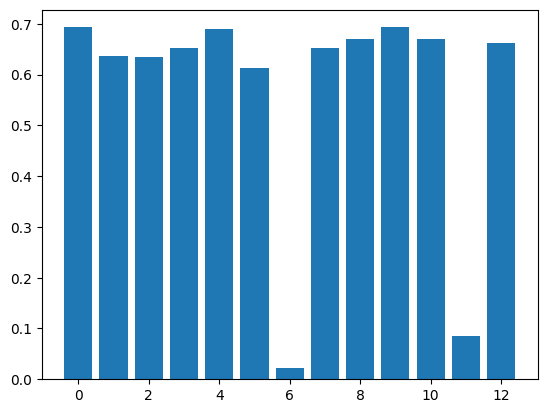

In [68]:
def compute_cluster_entropy(subdf):
    """
        Compute clusters entropy
    """
    nbpos = len(subdf[subdf.label == 1])
    nbneg = len(subdf[subdf.label == -1])

    ppos = nbpos / (nbpos + nbneg)
    pneg = nbneg / (nbpos + nbneg)

    H = - (ppos * np.log(ppos) + pneg * np.log(pneg))
    return H

plt.bar(x=np.arange(13), height=data.groupby("c").apply(compute_cluster_entropy))


Given the above entropies we transform it into a distribution with a softmax function. The softmax has soften the difference a low so we apply a low temperature to increase the differences.

<BarContainer object of 13 artists>

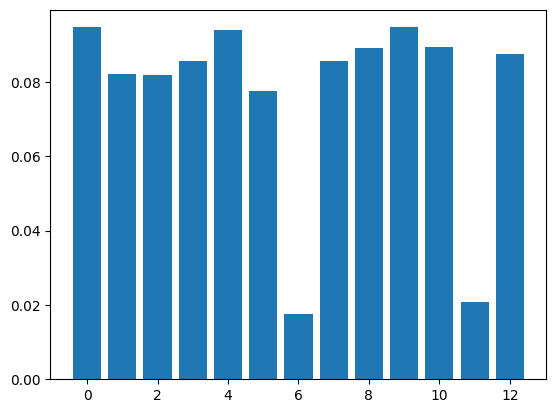

In [76]:
softmax = lambda x, T : np.exp(x / T) / np.exp(x / T).sum()

plt.bar(x=np.arange(13), height=softmax(data.groupby("c").apply(compute_cluster_entropy), 0.4))

In [124]:
def entropy_split(cds, n_samples):
    pdist = softmax(cds.groupby("c").apply(compute_cluster_entropy), 0.4) * n_samples
    def subsample(x):
        cluster = x.c.values[0]
        return x.sample(min(len(x), int(pdist[cluster])))
    return cds.groupby("c")\
        .apply(subsample)\
        .drop(["index", "c_dl2", "c_cos"], axis=1)\
        .reset_index(drop=True)

In [133]:
subds21 = entropy_split(data, 140_000)
subds22 = entropy_split(data, 200_000)

display(subds21[["c", "idx"]].groupby("c").count().T)
display(subds22[["c", "idx"]].groupby("c").count().T)

c,0,1,2,3,4,5,6,7,8,9,10,11,12
idx,13252,11477,11455,11969,13135,10854,2474,11980,12491,13248,12507,2900,12252


c,0,1,2,3,4,5,6,7,8,9,10,11,12
idx,18932,16396,16365,17099,18765,15506,3535,17115,17844,18925,17867,4142,17503


In [131]:
subds21

,idx,embedding,label,c
0,708877,"[0.067240335, 0.06290099, 0.14483646, -0.01492...",1,0
1,346462,"[0.10175563, 0.14040183, 0.10124556, -0.158098...",-1,0
2,370436,"[0.05720459, 0.20737337, 0.12614322, -0.268095...",-1,0
3,785471,"[0.1607685, 0.346893, 0.09451271, -0.13349523,...",1,0
4,889689,"[0.18612179, 0.22220623, 0.28254434, -0.116248...",1,0
...,...,...,...,...
139989,298247,"[0.11176144, 0.28548482, 0.12659284, -0.030072...",-1,12
139990,333831,"[0.21918395, 0.29948276, 0.0976548, -0.0288797...",-1,12
139991,899678,"[0.1540677, 0.37083036, 0.11831729, -0.0081001...",1,12
139992,263040,"[-0.084162295, 0.3635049, 0.031361356, 0.08417...",-1,12


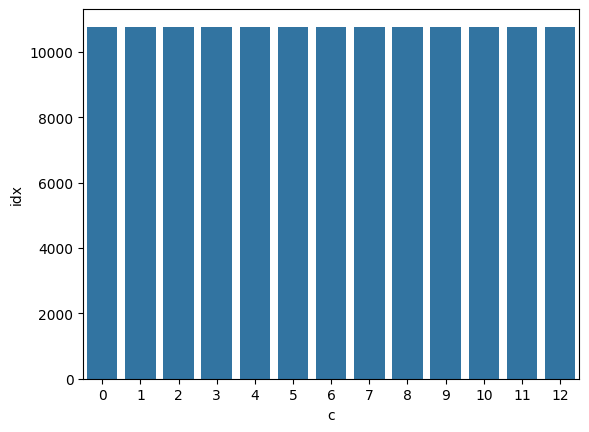

In [139]:
g = sns.barplot(data=subds1[["c", "idx"]].groupby("c").count(),
                x="c",
                y="idx")

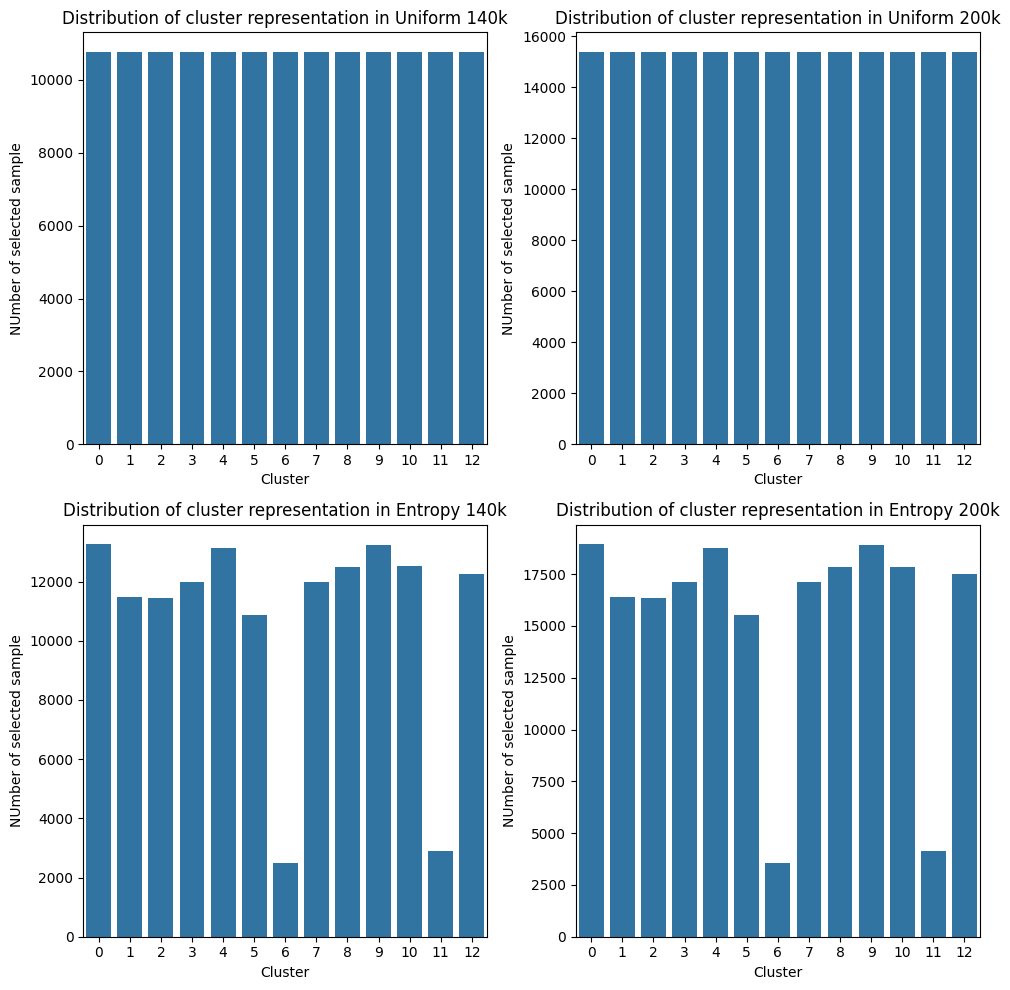

In [140]:
f, a = plt.subplots(2, 2, figsize=(10, 10))

def print_bar(df, ax, dsname):
    g = sns.barplot(
                data=df[["c", "idx"]].groupby("c").count(),
                ax=ax,
                x="c",
                y="idx"
    )
    g.set_title(
        f"Distribution of cluster representation in {dsname}"
    )
    g.set_xlabel("Cluster")
    g.set_ylabel("NUmber of selected sample")

print_bar(subds1, a[0][0], dsname="Uniform 140k")
print_bar(subds2, a[0][1], dsname="Uniform 200k")
print_bar(subds21, a[1][0], dsname="Entropy 140k")
print_bar(subds22, a[1][1], dsname="Entropy 200k")
plt.tight_layout()

In [143]:
with open('./data/twitter-datasets/train_neg_full.txt') as f:
    neg_samples = f.readlines()[:min(N_POS, N_NEG)]
with open('./data/twitter-datasets/train_pos_full.txt') as f:
    pos_samples = f.readlines()[:min(N_POS, N_NEG)]

all_tweets = neg_samples + pos_samples
print(len(all_tweets))

1000000


In [145]:
subds1

,idx,embedding,label,c
0,529063,"[0.42364442, 0.261242, 0.121312775, -0.2214074...",1,0
1,31520,"[0.2661021, 0.3132748, 0.070532896, -0.1294021...",-1,0
2,823257,"[-0.1308777, 0.29905, 0.1165197, -0.08845097, ...",1,0
3,684900,"[0.20141739, 0.2789873, 0.3249399, -0.17380853...",1,0
4,649974,"[0.27011698, 0.2830384, 0.047673576, -0.182575...",1,0
...,...,...,...,...
139992,759783,"[0.23800385, 0.24588406, 0.21405864, -0.113953...",1,12
139993,791121,"[0.3594375, 0.2632302, 0.1686678, -0.06187193,...",1,12
139994,713660,"[0.19263361, 0.2703056, 0.14085415, -0.1338064...",1,12
139995,122938,"[0.14651985, 0.2917968, -0.07531096, -0.082352...",-1,12


In [151]:
data["tweet"] = all_tweets

nsds = []
for subds in [subds1, subds2, subds21, subds22]:
    init_len = len(subds)
    assert(len(subds.merge(data[["idx", "tweet"]], how="left", on="idx")) == init_len)
    nsds.append(subds.merge(data[["idx", "tweet"]], how="left", on="idx"))

In [160]:
def write_pickle(data, fname):
    with open(f"{fname}_train.pkl", "wb") as f:
        pickle.dump(data, f)

write_pickle(nsds[0], "./data/twitter-datasets/aware_sampling_unif_140")
write_pickle(nsds[1], "./data/twitter-datasets/aware_sampling_unif_200")
write_pickle(nsds[2], "./data/twitter-datasets/aware_sampling_entr_140")
write_pickle(nsds[3], "./data/twitter-datasets/aware_sampling_entr_200")

In [165]:
AS_TYPES = ["unif_140", "unif_200", "entr_140", "entr_200"]
def load_aware_sampling(as_type=AS_TYPES[0]):
    if(as_type not in AS_TYPES):
        raise ValueError(f"Aware sampling type must be one of {AS_TYPES}")
    
    with open(f"./data/twitter-datasets/aware_sampling_{as_type}_train.pkl", 'rb') as f:
        return pickle.load(f)
    

load_aware_sampling("unif_140")

,idx,embedding,label,c,tweet
0,529063,"[0.42364442, 0.261242, 0.121312775, -0.2214074...",1,0,<user> aaa fasho ! ! ! im trying to go to magi...
1,31520,"[0.2661021, 0.3132748, 0.070532896, -0.1294021...",-1,0,<user> neither did i but if i do get to go thi...
2,823257,"[-0.1308777, 0.29905, 0.1165197, -0.08845097, ...",1,0,"<user> an older release , but one on my to rea..."
3,684900,"[0.20141739, 0.2789873, 0.3249399, -0.17380853...",1,0,<user> dont drool too much hahahahahah tell me...
4,649974,"[0.27011698, 0.2830384, 0.047673576, -0.182575...",1,0,<user> hahah i dont know if you'll get this or...
...,...,...,...,...,...
125992,172749,"[-0.03969761, 0.13129275, -0.038851634, -0.028...",-1,11,hyperaptive - believe ( music video <url> via ...
125993,72566,"[-0.07486319, 0.17652977, 0.12401445, -0.00285...",-1,11,x ( w / dvd ) ( spec the wait is finally over ...
125994,1772,"[0.1161805, 0.27589333, -0.017512837, -0.13090...",-1,11,harper's magazine ( magazine this magazine is ...
125995,59767,"[-0.12574124, 0.18470061, 0.104140304, -0.2217...",-1,11,made you look : a book of picture puzzles ( sp...


In [171]:
from utils import load_aware_sampling


load_aware_sampling(return_type="ds", as_type="entr_200")[:3]

{'tweet': ['#iamtheluckyone april 20th <url> i hope i win ! ! ! i love <user> cant wait to see the movie today ! ! #pleasepickme2win\n',
  '<user> oi ! respect ur elders ! lol i reckon half the crowd will be fainting .. he aint got time to rescue every 1 .. #imtherealsuperwoman\n',
  '<user> <user> it is ! sigh ... now i will never know ;p\n'],
 'labels': [1, 1, 0]}

## Dataset statistic

In [81]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from time import time
from utils import (load_aware_sampling,
                   AS_TYPES)

%load_ext autoreload
%autoreload 2




def dataset_statistic(ds):

    """"""
    start = time()
    tweet_len = ds["tweet"].apply(lambda x : len(x.split(" ")))
    pos_ratio = ds["labels"].mean()
    print("Stat prod time : ", round(time() - start, 2), "s")
    return {
        "avg_tweet_len": tweet_len.mean(),
        "pos_ratio": pos_ratio,
        "data_size": len(ds),
    }

all_stats = []
for as_type in AS_TYPES:
    stat = dataset_statistic(
        load_aware_sampling(data_path="data/twitter-datasets/", return_type="df", as_type=as_type)
    )
    stat["dataset"] = f"{as_type}"
    all_stats.append(
        stat
    )
for _ in range(10):
    stat = dataset_statistic(
            create_datasets(sub_sampling=140_000, return_type="df").reset_index()
        )
    
    stat["dataset"] = f"random"
    all_stats.append(
        stat
    )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Stat prod time :  0.05 s
Stat prod time :  0.07 s
Stat prod time :  0.05 s
Stat prod time :  0.06 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s
Stat prod time :  0.07 s


In [82]:
dataset_statistic(
    create_datasets(return_type="df").reset_index()
)

Stat prod time :  0.98 s


{'avg_tweet_len': 15.742243406205276, 'pos_ratio': 0.5, 'data_size': 2500002}

Start for number of characters
count    2.500000e+06
mean     7.596408e+01
std      3.542579e+01
min      3.000000e+00
25%      4.600000e+01
50%      7.100000e+01
75%      1.110000e+02
max      4.010000e+02
Name: nbchar, dtype: float64
Start for number of words
count    2.500000e+06
mean     1.401227e+01
std      6.357145e+00
min      1.000000e+00
25%      9.000000e+00
50%      1.400000e+01
75%      1.900000e+01
max      6.900000e+01
Name: nbwords, dtype: float64


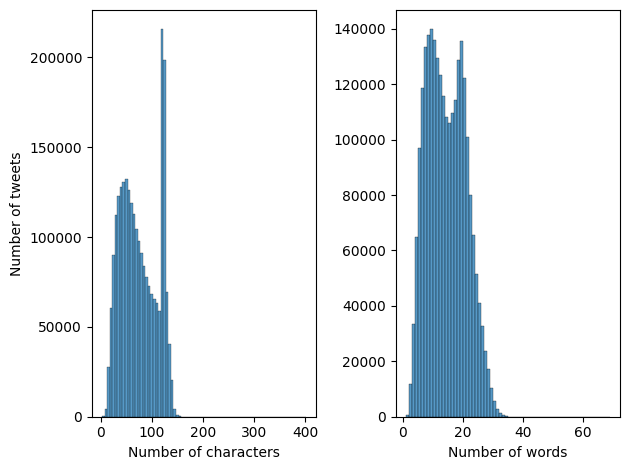

In [69]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

f, a = plt.subplots(1, 2)

completedf = create_datasets(return_type="df")
completedf["nbchar"] = completedf.tweet.apply(len)
completedf["nbwords"] = completedf.tweet.apply(
    lambda tweet : len(tokenizer.tokenize(tweet))
)

print("Start for number of characters")
print(completedf.nbchar.describe())

print("Start for number of words")
print(completedf.nbwords.describe())



g = sns.histplot(data=completedf, x="nbchar", ax=a[0], binwidth=5)
g.set_ylabel("Number of tweets")
g.set_xlabel("Number of characters")
g = sns.histplot(data=completedf, x="nbwords", ax=a[1], binwidth=1)
g.set_ylabel("")
g.set_xlabel("Number of words")
plt.tight_layout()
plt.savefig("complete_data_stat.pdf", dpi=1000)

In [15]:
print(pd.DataFrame(all_stats).groupby("dataset").mean().to_latex())

\begin{tabular}{lrrr}
\toprule
 & avg_tweet_len & pos_ratio & data_size \\
dataset &  &  &  \\
\midrule
entr_140 & 15.161389 & 0.564011 & 125994.000000 \\
entr_200 & 15.163483 & 0.565208 & 179994.000000 \\
random & 15.738909 & 0.499774 & 140000.000000 \\
unif_140 & 16.041017 & 0.504488 & 125997.000000 \\
unif_200 & 16.020651 & 0.502983 & 179992.000000 \\
\bottomrule
\end{tabular}



In [54]:
statdf = pd.DataFrame(all_stats)
statdf = statdf[statdf.dataset == "random"]

statdf.groupby("dataset").agg({
    "avg_tweet_len": lambda x : (x.mean(), x.std()),
    "pos_ratio" : lambda x : (x.mean(), x.std()),
})

,avg_tweet_len,pos_ratio
dataset,,
random,"(15.749315714285714, 0.013409949431827517)","(0.4997414285714285, 0.0011073287094392136)"


#### 6 - Study special tokens 

In [6]:
df = create_datasets(return_type="df")
df.head()

,labels,tweet
0,0.0,<user> i cant ! dont leave me on my own and yo...
1,0.0,<user> i think imma go to urgent care tomorrow
2,1.0,now we are 4 admins u want to be an admin ... ?
3,0.0,<user> i miss skins #greatshow they cancelled ...
4,0.0,the most beautiful gardens in the world ( hard...


In [12]:
import re

PATTERN = r'<(.*?)>'
df["special_tokens"] = df.tweet.apply(lambda x : re.findall(PATTERN, x))

In [16]:
df.explode("special_tokens")["special_tokens"].value_counts()[:2]

special_tokens
user    1601566
url      523990
Name: count, dtype: int64

They are only two special token that are anonymized, `user` and `url`, what a about ther types of senstive information.

### 7 - We produce a dataleakage free validation set

In [15]:
from utils import load_aware_sampling
%load_ext autoreload
%autoreload 2

AS_TYPES = ["unif_140", "unif_200", "entr_140", "entr_200"]

full_selected_tweet = pd.concat([
    load_aware_sampling(as_type=aware_sampling_type, split="train", return_type="df")
    for aware_sampling_type in AS_TYPES
]).drop_duplicates()

/Users/antoinemagron/Documents/EPFL/MA/MA3/ML/ml-project-2-apma_ai/utils.py:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(return_type in ["ds", "df"], "Return type either 'df' for DatFrame or 'ds' for Dataset")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## there are intersection (because sum clusters are underpopulated)
assert(len(full_selected_tweet) < sum([len(load_aware_sampling(as_type=aware_sampling_type, split="train", return_type="df"))
                                for aware_sampling_type in AS_TYPES]))

In [17]:
total_tweets = create_datasets(return_type="df")

LOADED NEGATIVE SAMPLES :  1250000
LOADED POSITIVE SAMPLES :  1250000


In [48]:
selected_tweets = set([x[:-1] for x  in full_selected_tweet.tweet.values])
not_seen_tweets = total_tweets[~total_tweets.tweet.isin(selected_tweets)]

assert(len(not_seen_tweets) < len(total_tweets) - len(selected_tweets))

In [50]:
not_seen_tweets.sample(10_000).to_csv("data/twitter-datasets/validation_set.csv", index=False)